## Regressor 학습  
- 2024년 7월 25일 
- skorch를 이용한 torch regressor와 sklearn의 Linear Regression을 비교 학습하였음  
- 데이터는 3개의 입력(metal온도, scr후단온도, 외기온도 for ts=0(연료투입시점)), 하나의 출력(배기가스온도 for ts=120, 5sec/tic)  
  - 1cc_warm(gt1+gt2) 64개, 1cc_hot(gt1) 89개, 1cc_hot(gt2) 89개를 사용함. data/0820/1cc_warm, 1cc_hot  
  - 데이터를 모두 합쳐서 학습한 것 보다 부류별로 분리하여 따로 학습한 것이 더 정확  
  - warm은 torch가 더 정확. hot는 linear reg가 더 정확

In [143]:
import numpy as np
from matplotlib import pyplot as plt

In [103]:
# 0:metal temp, 1:대기온도, 2:scr후단온도, 3:NH3투입량, 4:NOx, 5:배기가스온도, 6:Fuel_consumption
fnames = ['1cc_warm_all_nox3000.npy',
          '1cc_hot_gt1_nox3000.npy',
          '1cc_hot_gt2_nox3000.npy']

noxes = [np.load(fn) for fn in fnames]
noxes[0].shape, noxes[1].shape, noxes[2].shape

((64, 7, 3000), (89, 7, 3000), (89, 7, 3000))

In [157]:
train_x = np.concatenate([noxes[i][:,[0,1,2],0] for i in range(3)],0)
train_y = np.concatenate([noxes[i][:,5,120] for i in range(3)],0)
#train_x = train_x[64+89:]
#train_y = train_y[64+89:]
train_x = train_x[:64]
train_y = train_y[:64]

max_x, min_x = np.max(train_x, axis=0), np.min(train_x, axis=0)
max_y, min_y = np.max(train_y), np.min(train_y)

min_y = 0
train_x = (train_x-min_x) /(max_x-min_x)
train_y = (train_y-min_y) /(max_y-min_y)
train_y = np.expand_dims(train_y,1)

train_x.shape, train_y.shape, max_x, min_x, max_y, min_y, type(train_x), type(train_y)

((64, 3),
 (64, 1),
 array([496.61001587,  35.07247925, 240.05029297]),
 array([336.27996826,  -4.27610445,  64.33113861]),
 499.32635498046875,
 0,
 numpy.ndarray,
 numpy.ndarray)

### Skorch Regression

In [158]:
from skorch import NeuralNetRegressor
import torch
import torch.nn as nn


model = nn.Sequential(
    nn.Linear(3,32),
    nn.Softplus(),
    nn.Linear(32,16),
    nn.Softplus(),
    nn.Linear(16,1)
)

In [159]:
regressor = NeuralNetRegressor(model, max_epochs=1000, lr=0.0001, optimizer=torch.optim.Adam, 
                              iterator_train__shuffle=True, batch_size=32)
model

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In [161]:
train_x = torch.Tensor(train_x)
train_y = torch.Tensor(train_y)
regressor.fit(train_x, train_y)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0007        0.0006  0.0041
      2        0.0007        0.0006  0.0040
      3        0.0007        0.0005  0.0030
      4        0.0007        0.0005  0.0020
      5        0.0007        0.0006  0.0030
      6        0.0007        0.0006  0.0030
      7        0.0007        0.0005  0.0020
      8        0.0006        0.0005  0.0040
      9        0.0006        0.0005  0.0020
     10        0.0006        0.0005  0.0020
     11        0.0006        0.0005  0.0020
     12        0.0006        0.0005  0.0030
     13        0.0006        0.0005  0.0030
     14        0.0006        0.0005  0.0020
     15        0.0006        0.0005  0.0030
     16        0.0006        0.0005  0.0030
     17        0.0006        0.0005  0.0020
     18        0.0006        0.0005  0.0030
     19        0.0006        0.0005  0.003

    153        0.0004        0.0002  0.0030
    154        0.0004        0.0002  0.0030
    155        0.0004        0.0002  0.0020
    156        0.0004        0.0002  0.0030
    157        0.0004        0.0002  0.0030
    158        0.0004        0.0002  0.0020
    159        0.0004        0.0002  0.0030
    160        0.0004        0.0002  0.0030
    161        0.0004        0.0002  0.0030
    162        0.0004        0.0002  0.0030
    163        0.0004        0.0002  0.0030
    164        0.0004        0.0002  0.0020
    165        0.0004        0.0002  0.0020
    166        0.0004        0.0002  0.0030
    167        0.0004        0.0002  0.0030
    168        0.0004        0.0002  0.0030
    169        0.0004        0.0002  0.0030
    170        0.0004        0.0002  0.0030
    171        0.0004        0.0002  0.0050
    172        0.0004        0.0002  0.0030
    173        0.0004        0.0002  0.0020
    174        0.0004        0.0002  0.0020
    175        0.0004        0.0

    328        0.0003        0.0002  0.0020
    329        0.0003        0.0002  0.0040
    330        0.0003        0.0002  0.0020
    331        0.0003        0.0002  0.0020
    332        0.0003        0.0002  0.0030
    333        0.0003        0.0001  0.0030
    334        0.0003        0.0002  0.0020
    335        0.0003        0.0002  0.0030
    336        0.0003        0.0002  0.0030
    337        0.0003        0.0002  0.0030
    338        0.0003        0.0002  0.0030
    339        0.0003        0.0002  0.0040
    340        0.0003        0.0002  0.0020
    341        0.0003        0.0002  0.0030
    342        0.0003        0.0002  0.0020
    343        0.0003        0.0002  0.0020
    344        0.0003        0.0001  0.0030
    345        0.0003        0.0002  0.0020
    346        0.0003        0.0002  0.0020
    347        0.0003        0.0002  0.0030
    348        0.0003        0.0002  0.0030
    349        0.0003        0.0002  0.0030
    350        0.0003        0.0

    508        0.0003        0.0002  0.0040
    509        0.0003        0.0002  0.0030
    510        0.0003        0.0002  0.0030
    511        0.0003        0.0002  0.0020
    512        0.0003        0.0002  0.0030
    513        0.0003        0.0002  0.0020
    514        0.0003        0.0002  0.0030
    515        0.0003        0.0002  0.0040
    516        0.0003        0.0002  0.0020
    517        0.0003        0.0002  0.0040
    518        0.0003        0.0002  0.0030
    519        0.0003        0.0002  0.0050
    520        0.0003        0.0002  0.0030
    521        0.0003        0.0002  0.0040
    522        0.0003        0.0002  0.0030
    523        0.0003        0.0002  0.0020
    524        0.0003        0.0002  0.0030
    525        0.0003        0.0002  0.0030
    526        0.0003        0.0002  0.0020
    527        0.0003        0.0002  0.0020
    528        0.0003        0.0001  0.0030
    529        0.0003        0.0001  0.0040
    530        0.0003        0.0

    690        0.0003        0.0002  0.0050
    691        0.0003        0.0002  0.0040
    692        0.0003        0.0002  0.0030
    693        0.0003        0.0002  0.0020
    694        0.0003        0.0002  0.0030
    695        0.0003        0.0002  0.0020
    696        0.0003        0.0002  0.0020
    697        0.0003        0.0002  0.0020
    698        0.0003        0.0002  0.0020
    699        0.0003        0.0002  0.0030
    700        0.0003        0.0002  0.0020
    701        0.0003        0.0002  0.0030
    702        0.0003        0.0002  0.0030
    703        0.0003        0.0002  0.0040
    704        0.0003        0.0002  0.0020
    705        0.0003        0.0002  0.0030
    706        0.0003        0.0002  0.0030
    707        0.0003        0.0002  0.0030
    708        0.0003        0.0001  0.0020
    709        0.0003        0.0001  0.0030
    710        0.0003        0.0002  0.0020
    711        0.0003        0.0002  0.0020
    712        0.0003        0.0

    876        0.0003        0.0002  0.0030
    877        0.0003        0.0002  0.0030
    878        0.0003        0.0002  0.0030
    879        0.0003        0.0002  0.0020
    880        0.0003        0.0002  0.0040
    881        0.0003        0.0002  0.0030
    882        0.0003        0.0002  0.0020
    883        0.0003        0.0002  0.0030
    884        0.0003        0.0002  0.0020
    885        0.0003        0.0002  0.0030
    886        0.0003        0.0002  0.0030
    887        0.0003        0.0002  0.0020
    888        0.0003        0.0002  0.0020
    889        0.0003        0.0002  0.0030
    890        0.0003        0.0002  0.0030
    891        0.0003        0.0002  0.0040
    892        0.0003        0.0002  0.0020
    893        0.0003        0.0002  0.0020
    894        0.0003        0.0002  0.0020
    895        0.0003        0.0002  0.0030
    896        0.0003        0.0002  0.0030
    897        0.0003        0.0002  0.0030
    898        0.0003        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=16, out_features=1, bias=True)
  ),
)

In [164]:
out = regressor.predict(train_x)
out2 = np.concatenate([out*max_y, train_y*max_y], 1)
out2, out2.shape

(array([[461.63477, 452.2522 ],
        [463.76675, 454.7523 ],
        [473.1047 , 464.286  ],
        [466.90338, 456.35736],
        [468.67133, 459.75464],
        [472.07324, 463.82294],
        [476.0011 , 478.21298],
        [480.76108, 474.14032],
        [491.1711 , 482.56705],
        [495.77197, 485.66006],
        [492.6597 , 493.3842 ],
        [498.7242 , 492.84076],
        [491.93246, 489.9101 ],
        [496.42294, 486.81372],
        [491.94064, 482.58746],
        [484.99725, 485.29086],
        [481.6794 , 480.39395],
        [487.20465, 488.57965],
        [485.0143 , 484.18112],
        [471.43665, 468.62363],
        [460.66702, 452.6805 ],
        [454.05573, 445.55978],
        [463.0678 , 459.74487],
        [465.53464, 460.1085 ],
        [466.33298, 447.64212],
        [466.51184, 448.0612 ],
        [461.15042, 450.95764],
        [469.46054, 458.42343],
        [465.89087, 460.62784],
        [460.86322, 454.74756],
        [466.8863 , 453.80814],
        

### Linear Regression

In [165]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# 모델 생성 및 학습
model2 = LinearRegression()
model2.fit(train_x, train_y)

# 예측
y_pred = model2.predict(train_x)

# 성능 평가
mse = mean_squared_error(train_y, y_pred)
print(mse)
out3 = np.concatenate([out*max_y, y_pred*max_y, train_y*max_y], 1)
out3

0.00028698053


array([[461.63477, 460.3994 , 452.2522 ],
       [463.76675, 462.60217, 454.7523 ],
       [473.1047 , 472.04578, 464.286  ],
       [466.90338, 465.4634 , 456.35736],
       [468.67133, 467.21338, 459.75464],
       [472.07324, 470.7563 , 463.82294],
       [476.0011 , 476.5298 , 478.21298],
       [480.76108, 478.7829 , 474.14032],
       [491.1711 , 488.84082, 482.56705],
       [495.77197, 492.53833, 485.66006],
       [492.6597 , 488.91342, 493.3842 ],
       [498.7242 , 493.41202, 492.84076],
       [491.93246, 490.80252, 489.9101 ],
       [496.42294, 492.88495, 486.81372],
       [491.94064, 488.5399 , 482.58746],
       [484.99725, 484.3918 , 485.29086],
       [481.6794 , 481.45734, 480.39395],
       [487.20465, 486.28433, 488.57965],
       [485.0143 , 484.51053, 484.18112],
       [471.43665, 470.7947 , 468.62363],
       [460.66702, 458.3391 , 452.6805 ],
       [454.05573, 450.8164 , 445.55978],
       [463.0678 , 462.9213 , 459.74487],
       [465.53464, 464.76428, 460.

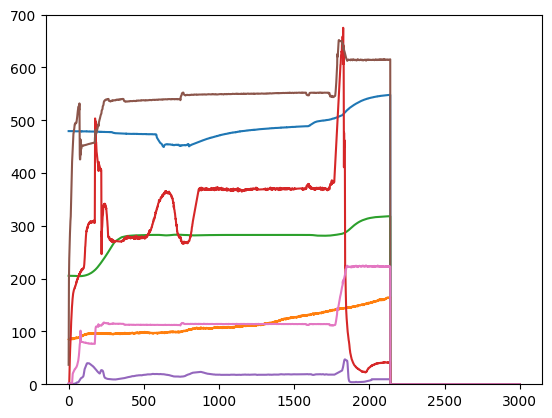

In [30]:
plt.ylim(0,700)
for i in range(7):
    vv = noxes[0][30,i,:3000]
    if i==1 or i==6:
        vv = vv*30
    plt.plot(vv)